"""
📘 Script: xgboost_model_training
--------------------------------------------------
Purpose:
- Train an XGBoost classifier to predict candidate-job fit using structured and text features.
- Preprocess text using TF-IDF, categorical features using OneHotEncoder, and numerical using StandardScaler.
- Handle class imbalance via `scale_pos_weight`.
- Use SHAP to explain model decisions and feature importance.

Inputs:
- ../data/processed/train.csv
- ../data/processed/test.csv
- ../data/processed/train_labels.csv
- ../data/processed/test_labels.csv

Outputs:
- Trained XGBoost model pipeline saved as: ../models/xgb_pipeline.joblib
- SHAP summary plot for feature importance
"""

In [5]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, average_precision_score
import shap
import matplotlib.pyplot as plt
import joblib

In [6]:
# --- Load Data ---
X_train = pd.read_csv("../data/processed/train.csv")
y_train = pd.read_csv("../data/processed/train_labels.csv").squeeze()
X_test = pd.read_csv("../data/processed/test.csv")
y_test = pd.read_csv("../data/processed/test_labels.csv").squeeze()

# --- Feature Setup ---
text_cols = ['candidate_skills', 'past_job_titles', 'certifications', 'required_skills', 'job_description']
cat_cols = ['education_level', 'candidate_location', 'job_location', 'job_title']
num_cols = [col for col in X_train.columns if col not in text_cols + cat_cols]

# --- Preprocessing Pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=300), "combined_text"),  # will be added as a combined field
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

In [7]:
# Combine text columns into a single column for TF-IDF
def combine_text(df):
    return df[text_cols].fillna("").agg(" ".join, axis=1)

X_train["combined_text"] = combine_text(X_train)
X_test["combined_text"] = combine_text(X_test)

# --- XGBoost Model ---
scale = (y_train == 0).sum() / (y_train == 1).sum()
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale,  # Adjust for class imbalance
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

# --- Full Pipeline ---
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])


In [8]:
# --- Train ---
pipeline.fit(X_train, y_train)

# --- Predict ---
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# --- Evaluation ---
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("PR AUC (Average Precision):", average_precision_score(y_test, y_proba))

/Users/nikhilraj/Documents/HiringAiModel/hiring-ml-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       961
           1       0.67      0.36      0.47        39

    accuracy                           0.97      1000
   macro avg       0.82      0.68      0.73      1000
weighted avg       0.96      0.97      0.96      1000

PR AUC (Average Precision): 0.536988023252203


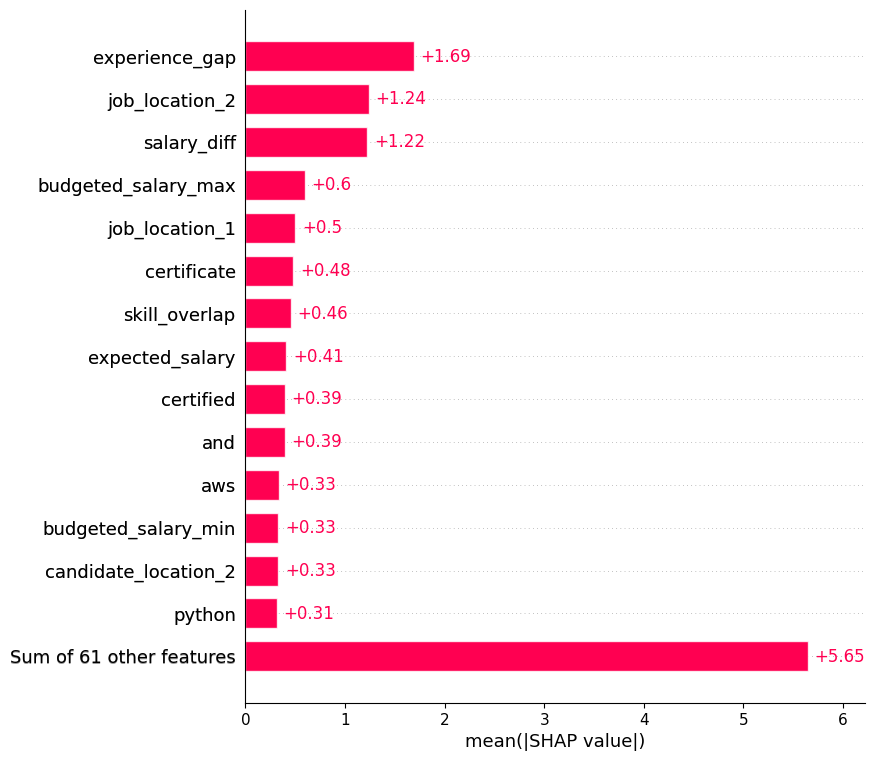

['../models/xgb_pipeline.joblib']

In [9]:




# --- SHAP Explainability ---
X_test_proc = pipeline.named_steps["preprocessor"].transform(X_test)

# Use TreeExplainer with raw model
explainer = shap.Explainer(pipeline.named_steps["classifier"])

# Get all transformed feature names
tfidf_features = pipeline.named_steps["preprocessor"] \
    .named_transformers_["text"] \
    .get_feature_names_out(input_features=["combined_text"])

cat_features = pipeline.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(cat_cols)

all_features = np.concatenate([tfidf_features, cat_features, num_cols])

X_test_df = pd.DataFrame(X_test_proc.toarray() if hasattr(X_test_proc, "toarray") else X_test_proc,
                         columns=all_features)
shap_values = explainer(X_test_df)


# SHAP summary plot
shap.plots.bar(shap_values, max_display=15, show=True)

# --- Save Model ---
joblib.dump(pipeline, "../models/xgb_pipeline.joblib")



"""
Conclusion:

The XGBoost model achieves high overall accuracy (97%) and performs well on the majority class (class 0),
 with precision and recall near 0.97–0.99. 
However, performance on the minority class (class 1 — suitable candidates) is significantly lower, 
with a recall of 0.36 and precision of 0.67. 
This indicates that while the model is good at identifying unsuitable candidates, it struggles to correctly 
identify many of the suitable ones. 
The PR AUC of ~0.54 also reflects this imbalance. Further improvement is needed—potentially via advanced resampling, 
model ensembles, or cost-sensitive learning—to better capture the minority class.
"""
